# PubTabNet Playground
_A rule-based approach to paring tabular data from images._

### What is table parsing?
Loosely speaking the objective of a table parsing algorithm is to convert an image of a table, extracted from a scanned document for example, into
a csv.


![1](imgs/1.png)

Tissues, Wild-type rabbits, hLPL rabbits,<br>
Perirenal fat, 1305±336, 1420±500,<br>
...

### Why is table parsing?
The need for a fully optical table parsing algorithm is part of a larger need for a fully optical document parsing engine. Say, for example,
there is a pdf document of a textbook, but it is just a collection of scanned images. It would be great if there was a way to search for keywords within that document. Indeed this technology does exist and has existed for quite some time. This capability can be obtained using Optical Character Recognition (OCR) which has been commonly available since the 1970s. The information age has brought with it a host of fancy Natural Language Processing (NPL) utilities such as entity recognition, text summarization, etc. Our ability to apply connect these two technologies together, i.e. applying NLP utilities on the words found within a scanned document, however, has remained an elusive target for a number of reasons that I won't go into directly. However, many of the principle roadblocks with regards to parsing tabular data from images share commonalities with those of parsing documents in general.

### Who is table parsing?
For the purposes of this task, tables can categorized into one of four groups; good, bad, twice as bad, and slightly worse. The example above is a good one. Here is a bad table.

![2](imgs/2.png)

What is wrong with this table is the existance of multiple column headers. I.e., "Model 1" and "Model 3" are sub-columns of "CN Interactions". Here is another bad example. In this example, there are rows which should be interpreted as subcategories of other rows.

![3](imgs/3.png)

Naturally, the twice as bad category refers to tables which have both multi-columns and multi-rows. The final category "slightly worse" refers to tables which are slanted. Here is a figure from "Rethinking Table Recognition using Graph Neural Networks" (Qasim) which includes all four (and is the source of this categorization methodology)

![4](imgs/4.PNG)

This categorization is an artifact of traditional methods for parsing tables which can be summarized as; Perform OCR on the image to determine the coordinates of the data values and fit the values to a cartesian grid. Qasim proposes an ingeneous algorithm which bypasses the roadblocks associated with fitting non-grid-like items to a grid, by reformulating the problem into one of relationship prediction. Unfortunately, I found this paper quite late in my research and did not have time to experiment with the proposed model, so this article is my best attempt at solving a the problem using the traditional thought process; find the data values, fit them to a grid.


### When is table parsing?
In 2020, IBM released PubTabNet, a dataset aimed at solving this problem once and for all. The dataset consists of images of tables as the input. The target is the XML used to generate each image, which I have taken the liberty to process into a more usable format in a separate module.

### The code

In [1]:
from pathlib import Path

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from PubTabNetDataset import PubTabNet
from TesseractUtils import im_to_data, scale

PubTabNetDataset and TesseractUtils are custom modules that make the code a bit more consice. Primarily they handle loading the dataset and all of the OCR processing and output formatting. They can be found in the repo.
### Load the data

In [4]:
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"
target_path = data_dir / "PubTabNet_2.0.0.jsonl"
TrainDataset = PubTabNet(train_dir, target_path)

### Utility Functions

In [5]:
COLORS = {
    'black':(0,0,0),
    'red':(150,0,0),
    'green':(0,150,0),
    'blue':(0,0,150)
}

def draw(im, bbox, color='black'):
    im = np.array(im)  # in case it is in PIL format
    x, y, w, h = bbox
    # w = x2 - x
    # h = y2 - y
    W,H,_ = im.shape
    
    if isinstance(color, str):
        color = COLORS[color]
    
    pt1 = (x, y)
    pt2 = (x+w, y+h)
    return cv2.rectangle(im, pt1=pt1, pt2=pt2,
        color=color, thickness=1
    )

### Inspecting the data

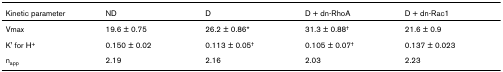

In [6]:
im, trg = TrainDataset[0]
im

In [7]:
trg[0]

{'col_start': 0,
 'col_end': 0,
 'row_start': 0,
 'row_end': 0,
 'is_head': True,
 'is_body': False,
 'raw': '<thead><tr><td></td>',
 'text': ('Kinetic parameter',),
 'bbox': [5, 9, 66, 19]}

Essentially we have the bounding box of each cell in terms of the pixel coordinates and the cell coordinate, and whether or not the cell is part of the header.

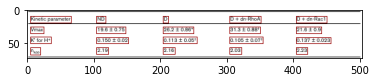

In [8]:
cp = im.copy()
for cell in trg:
    x, y, x2, y2 = cell["bbox"]
    w = x2 - x
    h = y2 - y
    cp = draw(cp, (x,y,w,h), "red")
plt.imshow(cp)

We want to get all of that data from the image. As mentioned before the first step is to perform OCR

### OCR
Again, this `im_to_data` function is defined in a separate script which is included in the repo. The primary function is to reformat the raw text output from Tesseract into a dataframe. `scaling_factor` takes care of scaling up the image (for better OCR results) and scaling the resulting bboxes back down to the original size.

In [9]:
df = im_to_data(im, scaling_factor=3)
df.head()

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,4,5,1,1,1,1,1,6,10,22,6,94.0,Kinetic
1,5,5,1,1,1,1,2,31,11,34,6,95.0,parameter
2,6,5,1,1,1,1,3,100,8,16,10,86.0,ND
3,7,5,1,1,1,1,4,206,8,3,10,30.0,BD
4,8,5,1,1,1,1,5,305,10,5,6,73.0,0


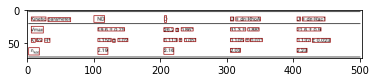

In [10]:
# show the bboxes for fun
cp = im.copy()
for bbox in df[["left", "top", "width", "height"]].values:
    cp = draw(cp, bbox, "red")
plt.imshow(cp)

### Grid detection
The general strategy here is to try and segment the image vertically and horizontally, using the slices devoid of any text as markers for a column/row boundary. To accomplish this, we'll use the boxes returned by tesseract to identify regions of text, then examine the vertical and horizontal slices of the mask to try and detect gaps in content.

In [11]:
mask = np.zeros(im.size)
for bbox in df[['left', 'top', 'width', 'height']].values:
    x,y,w,h = bbox
    mask[x:x+w,y:y+h]=1

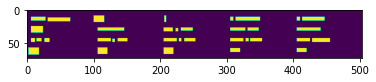

In [12]:
plt.imshow(mask.T)

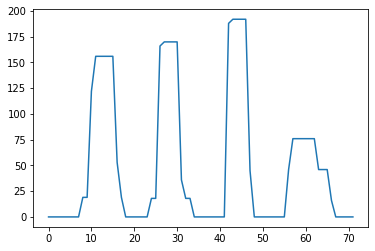

In [13]:
# vertical text distribution
plt.plot(mask.sum(axis=0))

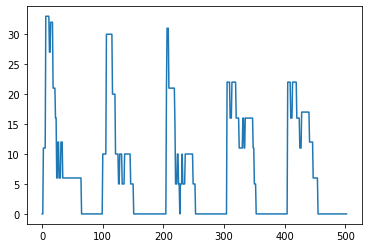

In [14]:
# horizontal text distribution
plt.plot(mask.sum(axis=1))

The following function attempts to detect the minima in those two plots in order to determine the vertical and horizontal locations at which the table should be split

In [59]:
def grid_detect(
    im,
    v_thresh=0.05,
    h_thresh=0.05,
    min_v_gap = 5, # pixels
    min_h_gap = 10, # pixels
):
    """
    im <PIL.Image or imarray>: Image of a table
        
    v_thresh <float> (0.1): Threshold for considering a row of pixels to be considered
        a vertical boundary in the grid. Higher values mean fewer rows.
        
    h_thresh <float> (0.1): Threshold for considering a column of pixels to be considered
        a horizontal boundary in the grid. Higher values mean fewer columns.
    """
    # use Tesseract to find all words
    df = im_to_data(im, scaling_factor=3)

    # create a word mask from tesseract bboxes
    mask = np.zeros(im.size)
    for bbox in df[['left', 'top', 'width', 'height']].values:
        x,y,w,h = bbox
        mask[x:x+w,y:y+h]=1

    v_density = mask.sum(axis=0)/max(mask.sum(axis=0))
    h_density = mask.sum(axis=1)/max(mask.sum(axis=1))
    
    # scale up the density vectors so that the mean is equal to 0.2
    # this makes the thresholds directly related to the average density
    v_density = v_density / (np.mean(v_density)*4)
    h_density = h_density / (np.mean(h_density)*4)
    
    
    # move down the image and record spans which exceed the threshold for being considered a row
    grid_y = []
    to_del = set()
    y=0
    out=True
    for y,val in enumerate(v_density):
        if val>v_thresh and out:
            out=False
            if len(grid_y)==0 or y - grid_y[-1][-1] > min_v_gap:
                grid_y.append([y])
            else:
                grid_y[-1] = [grid_y[-1][0]]
        if val < v_thresh and not out:
            grid_y[-1].append(y)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_y)-1)
    
    
    # expand to fill
    grid_y[0][0]=0
    grid_y[-1][1]=im.size[1]-1
    for i in range(len(grid_y)-1):
        x1 = grid_y[i][1] # end of this
        x2 = grid_y[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_y[i][1]=m
        grid_y[i+1][0]=m
    
    grid_x = []
    to_del = set()
    x=0
    out=True
    for x,val in enumerate(h_density):
        if val>h_thresh and out:
            out = False
            if len(grid_x)==0 or x - grid_x[-1][-1] > min_h_gap:
                grid_x.append([x])
            else:
                grid_x[-1] = [grid_x[-1][0]]
        if not val>h_thresh and not out:
            grid_x[-1].append(x)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_x)-1)
    
    # expand to fill
    grid_x[0][0]=0
    grid_x[-1][1]=im.size[0]-1
    for i in range(len(grid_x)-1):
        x1 = grid_x[i][1] # end of this
        x2 = grid_x[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_x[i][1]=m
        grid_x[i+1][0]=m
    
    grid = []
    for y in grid_y:
        y1,y2 = y
        for x in grid_x:
            x1,x2 = x
            grid.append([x1,y1,x2-x1,y2-y1])
    return grid, df

In [67]:
im, trg = TrainDataset[2]

In [65]:
grid, df = grid_detect(im)

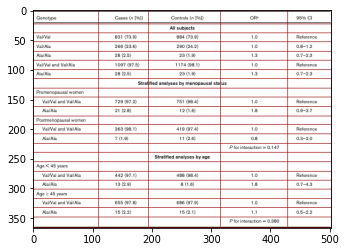

In [66]:
# show the bboxes for fun
cp = im.copy()
for bbox in grid:
    cp = draw(cp, bbox, "red")
plt.imshow(cp)

### Performance
That looks pretty good. But we need a metric to quantify the goodness. IBM has kindly provided a metric for just this purpose, but it doesn't quite fit the bill for this approach. The reason being, we kind of cheated. I did not pay any attention to the 4 categories mentioned above. Instead, the approach was to assume a matrix-like grid, which kind of ignores the spirit of the problem of _understanding_ or extracting the meaning of the table. But, it is suitable for my needs. This means we need to make our own metric.

The following metric determines the number of rows and columns that should be detected, and compares it to the number of columns and rows that were detected, divided by the number of rows and columns in the table.

In [83]:
def custom_metric(y_pred, y_actual):
    n_cols_actual = max([x["col_end"] for x in y_actual])+1
    n_rows_actual = max([x["row_end"] for x in y_actual])+1
    
    n_cols_pred = 0
    y_end = y_pred[0][-1]
    for bbox in y_pred:
        if bbox[1] >= y_end:
            break
        n_cols_pred += 1
        
    n_rows_pred = len(y_pred)/n_cols_pred
    return (abs(n_rows_pred - n_rows_actual)+abs(n_cols_actual-n_cols_pred))/(n_cols_actual+n_rows_actual)

In [85]:
scores = []
for i in range(100):
    im, trg = TrainDataset[i]
    grid, df = grid_detect(im)
    scores.append(custom_metric(grid, trg))
print(sum(scores)/len(scores))

0.1332841601375976


The goal here was to predict the number of columns and rows in the table. This algorithm acheived a mean absolute error of ~13%. While the metric is not particularly informative about overall performance, it is sufficient for tuning the parameters of the grid_detect function.